In [2]:
import re
import warnings
import numpy as np 
import pandas as pd
import lightgbm as lgb
import seaborn as sns


from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix, hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
movies_df = pd.read_csv("datasets/movies.csv")
train_df = pd.read_csv("datasets/train.csv")
test_df = pd.read_csv("datasets/test.csv")
sample_df = pd.read_csv("datasets/sample.csv")

Checking shape of csv

In [3]:
print(train_df.shape, test_df.shape, movies_df.shape, sample_df.shape)

(162758, 5) (55315, 4) (143258, 14) (55315, 2)


## Analyse train_df

In [6]:
train_df.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [7]:
train_df.dtypes

movieid               object
reviewerName          object
isFrequentReviewer      bool
reviewText            object
sentiment             object
dtype: object

In [9]:
train_df.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [57]:
train_df[train_df['reviewText'] == ""]

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment


In [4]:
for i in range(10):
    print(train_df['reviewText'][i])

Henry Selick’s first movie since 2009’s Coraline. His fifth stop-motion masterpiece.
With a cast that reads like the Vogue Oscar party guest list, Valentine's Day should have been can't-miss cinema instead of standard Hollywood schmaltz.
Creed II does not give us anything but another, slightly superior Rocky sequel. It wins on points. Just don't expect a knockout.
I know what you're thinking, but this is no Limitless (Bradley Cooper). As the cells multiply and Lucy taps into more and more of her brain, it's new thrills-new skills with each passing hour.
Director Fernando Meirelles tells the story with urgency, and his sharp visual compositions and washed out cinematography ooze gangster life.
"Kajillionaire" is a rich piece of storytelling, and it feels like a kajillion bucks.
A heartfelt story with a lovely performance from Scott Chambers.
If a bit long for a cartoon feature -- probably a sign that its makers fell in love with it -- Ratatouille is the eighth and one of the best Pixar 

In [59]:
train_df['sentiment'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

## Key findings from train_df

- There are only categorical variable, as I can observe.
- 'reviewText' column is apparently feels like more relatable for Sentiment Analysis.
- The only column containg 'Nan' values are 'reviewText'. It contains 6447 null values
- Observing special characters like '--', ', etc.
- There are no empty string.

- 'sentiment' column is the target column and contains two types of values.
    - POSITIVE
    - NEGATIVE

## Analyse movies_df

In [31]:
movies_df.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [34]:
movies_df.dtypes

movieid                  object
title                    object
audienceScore           float64
rating                   object
ratingContents           object
releaseDateTheaters      object
releaseDateStreaming     object
runtimeMinutes          float64
genre                    object
originalLanguage         object
director                 object
boxOffice                object
distributor              object
soundType                object
dtype: object

In [35]:
movies_df.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [48]:
movies_df.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [55]:
movies_df[movies_df['runtimeMinutes']==1].shape

(23, 14)

<Axes: xlabel='runtimeMinutes', ylabel='Count'>

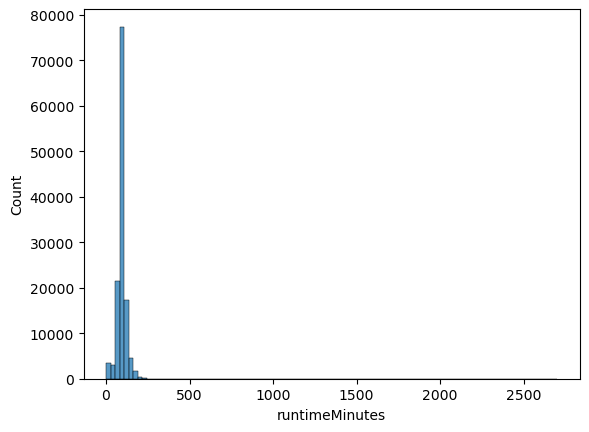

In [13]:
sns.histplot(data=movies_df['runtimeMinutes'], bins=100)

In [47]:
# NOTE: 70010 row are empty for audience
movies_df['audienceScore'].describe()

count    73248.000000
mean        55.674967
std         24.553648
min          0.000000
25%         37.000000
50%         57.000000
75%         76.000000
max        100.000000
Name: audienceScore, dtype: float64

<Axes: xlabel='audienceScore', ylabel='Count'>

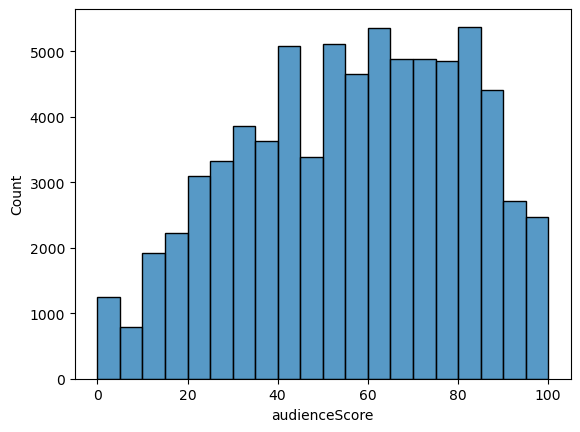

In [8]:
sns.histplot(data=movies_df['audienceScore'], bins=20)

In [65]:
missing_movies = train_df[~train_df['movieid'].isin(movies_df['movieid'])]
missing_movies

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment


In [66]:
missing_movies_test = test_df[~test_df['movieid'].isin(movies_df['movieid'])]
missing_movies_test

,movieid,reviewerName,isTopCritic,reviewText


## Key findings from movies_df

- There are categorical and numerical both types of features.
- Too many columns are containg Nan.
- NOTE: Choosing column containing too many null value will do no good for analysis.
- 'runtimeMinutes' is vague column containg minimum 1 and maximum 2700. Which is not an ideal length of movies. Feels unrelated.
- From all the columns 'audienceScore' looks like more relatable for Sentiment Analysis.
- 'movies_df' contains all the 'movieid' present in 'train_df' and 'test_df'


## Analyse test_df

In [73]:
test_df.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [76]:
test_df.isna().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [79]:
test_df.dtypes

movieid         object
reviewerName    object
isTopCritic       bool
reviewText      object
dtype: object

In [80]:
test_df[test_df['reviewText'] == '']

,movieid,reviewerName,isTopCritic,reviewText


In [81]:
for i in range(10):
    print(test_df['reviewText'][i])

Green slowly cranks up the dread with style and even occasional shards of wit. It is more of a psychological thriller than the previous films, and all the better for it.
Philip Noyce's direction is elegant and unforced, willing to let his admirable leads and the harsh beauty of the country speak for themselves.
It wouldn't do to say what path Maria ultimately takes... But that won't lessen the pleasure of the journey, or the stark scenery of Quebec's near north that serves as a stunning backdrop to the tale.
Pig is not exactly the arthouse John Wick that the synopsis might suggest, but this strangely emotional story of love and loss is dangerously seductive.
An imaginative no-budget musical of sorts about male same-sex desire whose freeform assertion of personal and collective identity may remind you of Marlon Riggs’ Tongues Untied.
Life happens... live it one day at a time and connect to whomever you can, even if it's the person losing their job sitting right across from you.
You can'

## Key findings from test_df

- 'reviewText' column is apparently feels like more relatable for Sentiment Analysis. (As it is one of the matched column with dataset train_df)
- The only column containg 'Nan' values are 'reviewText'. It contains 2510 null values
- Observing numbers special characters like '...', ', '#', etc in reviewText.
- There are no empty string.

## Function for Merging Data with "movis_df"

In [4]:
# Merge data and movies_df such that column arrangement and number of cloumns in data remains same
def merge_with_movies(data: pd.DataFrame)->pd.DataFrame:
    """
    Merge the 'data' with movies_df, merging only audienceScore column.
    """
    impute = SimpleImputer(strategy = "mean")
    movies_df["audienceScore"] = impute.fit_transform(movies_df[["audienceScore"]])
    # Group movies_df by "movieid" and calculate the mean audienceScore for each movie
    movies_df_grouped = movies_df.groupby("movieid")["audienceScore"].mean()
    mean_aud_score = movies_df["audienceScore"].mean()
    movieid = data["movieid"]
    audienceScore_arr = []
    # Iterate through each movieid in data
    for movie in movieid:
        # Get the mean audienceScore for the current movieid from movies_df_grouped
        # mean_aud_score --> is placed if a movie have audienceScore else mean_aud_score
        mean_audience_score = movies_df_grouped.get(movie,mean_aud_score)
        # Append the mean audienceScore to the audienceScore_arr list
        audienceScore_arr.append(mean_audience_score)
    data["audienceScore"] = audienceScore_arr
    # Print or use audienceScore_arr as needed
    print("from merge_with_movies's last line:  ", len(audienceScore_arr), movieid.shape)
    return data

> **PREPROCESSING**



In [5]:
#######################################
## cleaning text data
#######################################

# movies_df = movies_df.drop_duplicates()

# stop_words = [
#     "a", "about", "above", "after", "again", "against", "all", "am", "an", "and",
#     "any", "are", "aren't", "as", "at", "be", "because", "been", "before", "being",
#     "below", "between", "both", "but", "by", "can", "can't", "cannot", "could",
#     "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down",
#     "during", "each", "few", "for", "from", "further", "had", "hadn't", "has",
#     "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her",
#     "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's",
#     "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it",
#     "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself",
#     "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other", "ought",
#     "our", "ours", "ourselves", "out", "over", "own", "same", "shan't", "she",
#     "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such",
#     "than", "that", "that's", "the", "their", "theirs", "them", "themselves",
#     "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
#     "they've", "this", "those", "through", "to", "too", "under", "until", "up",
#     "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were",
#     "weren't", "what", "what's", "when", "when's", "where", "where's", "which",
#     "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would",
#     "wouldn't", "you", "you'd", "you'll", "you're", "you've", "your", "yours",
#     "yourself", "yourselves"
# ]

# def text_cleaner(text:str)->str:
#     """
#     Cleans the data.
#     """
#   if type(text) != str:
#     text = str(text)
#   text = text.lower() # convert to lowercase
#   if text == "nan":
#     text = " "
#   filter_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # remove punctuation and special characters
#   filter_text = re.sub(r'[0-9]', ' ', filter_text)
#   filter_text = re.sub(r'\s+', ' ', filter_text)
#   temp_list = []
#   filtered_set = set()
#   temp_text_list = filter_text.split(" ")
#   for word in temp_text_list:
#     if len(word) < 2:
#       continue
#     elif word[-3:] in ("ing", "ize") and len(word)>4:
#       word = word[:-3]
#       try:
#         if word[-1] == word[-2]:
#           word = word[:-1]
#       except:
#         print(word)
#     elif word[-4:] in ("ment",):
#       word = word[:-4]

#     if word in stop_words:
#       continue

#     else:
#       temp_list.append(word)
#       # filtered_set.add(word)
#   filter_text = " ".join(temp_list)
#   filter_text = re.sub(r'\s+', ' ', filter_text)

#   return filter_text


In [6]:
movies_df = movies_df.drop_duplicates()

def text_cleaner(text:str)->str:
    """
    Cleans the text.
    """
    if type(text) != str:
        text = str(text)
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # remove punctuation and special characters
    text = re.sub(r'[0-9]', ' ', text) # rempve numbers
    text = re.sub(r'\s+', ' ', text) # remove more than one white spaces
    return text


def preprocessing(data: pd.DataFrame, is_test_data: bool=False)->pd.DataFrame:
    """
    Preprocessing the data.
    """
    merged_data = merge_with_movies(data)
    print("shape after joing movies data",merged_data.shape)
    # Important features
    important_features = ['reviewText','sentiment','audienceScore']
    columns = merged_data.columns
    # deleting features not in important_features
    for col in columns:
        if col not in important_features:
            merged_data = merged_data.drop(col, axis=1)
    print("After removing rows containing null for particular column: " ,merged_data.shape) 
    if not is_test_data:  # operation that should not be done on test data
    # Create a LabelEncoder instance
        label_encoder = LabelEncoder()
        merged_data['sentiment'] = label_encoder.fit_transform(merged_data['sentiment'])
  # cleaning texts
    merged_data["reviewText"] = merged_data["reviewText"].apply(text_cleaner)
    # preprocessing audience score
    mean_audience_score = np.mean(merged_data["audienceScore"])
  
    # Calculate the interquartile range (IQR)
    q1 = merged_data["audienceScore"].quantile(0.25)
    q3 = merged_data["audienceScore"].quantile(0.75)
    iqr = q3 - q1
    # Step 3: Replace outliers with the mean
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    merged_data["audienceScore"] = merged_data["audienceScore"].apply(lambda x: x if (lower_bound <= x <= upper_bound) else mean_audience_score)
    # scaling "audienceScore"
    scaler = MinMaxScaler()
    merged_data["audienceScore"] = scaler.fit_transform(merged_data[["audienceScore"]])
    return merged_data

train_merged_data = preprocessing(train_df)

from merge_with_movies's last line:   162758 (162758,)
shape after joing movies data (162758, 6)
After removing rows containing null for particular column:  (162758, 3)


## Vectorizing the text data

In [7]:
t_vectorizer = TfidfVectorizer()
# vectorizing the dataset
encoded = t_vectorizer.fit_transform(train_merged_data["reviewText"])

data_series = train_merged_data["audienceScore"]
# Convert the pandas Series to a sparse matrix with the same number of rows as 'encoded'
data_series_sparse = csr_matrix(data_series.values.reshape(-1, 1))
# Combine the two sparse matrices horizontally (column-wise)
enc_with_audience_score = hstack([encoded, data_series_sparse])

In [8]:
enc_with_audience_score.shape

(162758, 64171)

In [21]:
enc_with_audience_score[:10].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59770115],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.44062848],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.77011494],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.85057471],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.73563218],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.47126437]])

## Spliting Train and Test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(enc_with_audience_score, train_merged_data["sentiment"], test_size=0.1, random_state=42)

## Training Different models

#### LogisticRegression Algorithm


In [ ]:
# ###############################
# ## NOTE : It takes too much time, so ran offline and used the result. Because of too many parameters to tune.

# ###############################
# param_grid = {
#     "penalty": ['elasticnet'],
#     "tol": [0.1, 0.01, 0.001, 0.0001],
#     "C": [0, 0.01, 0.1, 1.0],
#     "solver": ["saga", "liblinear", "lbfgs"],
#     "max_iter": [100, 1000],
#     "multi_class": ['auto', 'ovr', 'ova'],
#     "l1_ratio": [0, 0.5, 0.8]
# }
# lr = LogisticRegression()
# grid = GridSearchCV(lr, param_grid=param_grid, cv=5)
# grid.fit(X_train, y_train)

In [10]:
# #########################
# # NOTE: Good performance 
# #########################
# fine_tuned_lr = LogisticRegression(l1_ratio=0, penalty='elasticnet', solver='saga')
# fine_tuned_lr.fit(X_train, y_train)
# fine_tuned_lr.score(X_test, y_test)
# # # final score --> 0.81516

0.8189972966330794

#### Observation with LogisticRegression
- It works with probabilities.
- Data is linearly saperable.

#### Naive Bayes Algorithm

In [12]:
# #########################
# # NOTE: Bad performance
# #########################
# classifier = MultinomialNB()
# classifier.fit(X_train, y_train)
# classifier.score(X_test, y_test)

0.7373433275989186

#### Observation from MultinomialNB
- Probably sparsity of the data (more 0's) is affecting the model performence.


#### RandomForest Algorothm


In [14]:
# #########################
# # NOTE: Bad Performance and taking too much time
# #########################
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# classifier.score(X_test, y_test), accuracy_score(y_pred, y_test)

#### Observation from RandomForestClassifier
- Since there are too many features, creating decision trees is taking time. Therefore Its better to avoid random forest classifier.
- This classifier uses level wise growth of decisiion trees, this could be another reason for its slow speed.

#### LinearSVC Algorithm


In [75]:
# #########################
# # NOTE: Run in Local machine since takes too much time
# #########################

# # Create the classifier
# svm_classifier = LinearSVC(random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1.0, 10.0, 100.0],
#     'tol': [1e-4, 1e-3, 1e-2],
#     'max_iter': [100, 500, 1000],
# }

# # Create the GridSearchCV instance
# grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)

# # Fit the GridSearchCV to the data
# grid_search.fit(X_train, y_train)

# # Get the best model and its hyperparameters
# best_svm_classifier = grid_search.best_estimator_
# best_hyperparameters = grid_search.best_params_

# # Evaluating the best model on the training data
# train_accuracy = accuracy_score(y_train, best_svm_classifier.predict(X_train))
# print("Best Hyperparameters:", best_hyperparameters)
# print("Training accuracy with best hyperparameters:", train_accuracy)


In [25]:
# ##################################
# # Best score till now
# ##################################
svm_classifier = LinearSVC(C=0.1, max_iter=100, random_state=42, tol=0.01)
svm_classifier.fit(X_train, y_train)
svm_classifier.score(X_test, y_test)
##  final score --> 0.81525


0.8199188989923815

#### Observation from LinearSVC
- Since it is giving good score, hypothesis of data being linearly saperable looks true.
- It is properly handling sparsed dataset (dataset with multiple zeros). 

#### lightgbm algorithm

In [37]:
# #########################
# # NOTE: Run in Local machine since takes too much time
# #########################

# # Suppress LightGBM warnings
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning, message="[LightGBM]")

#     # Define the parameter distributions for RandomizedSearchCV
#     param_dist = {
#         'boosting_type': ['gbdt', 'dart', 'goss'],
#         'num_leaves': [15, 31, 50],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 6],  # -1 indicates no limit
#         'min_child_samples': [20, 50, 100],
#         'subsample': [0.8, 1.0],
#     }

#     # Create the RandomizedSearchCV object
#     random_search = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_dist,
#                                        scoring='accuracy', cv=3, verbose=2, n_jobs=-1, n_iter=10)

#     # Perform randomized search on the training data
#     random_search.fit(X_train, y_train)

#     # Get the best parameters and model
#     best_params = random_search.best_params_
#     best_model = random_search.best_estimator_

# # Make predictions on the test set
# predictions = best_model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, predictions)
# print("Best Parameters:", best_params)
# print("Accuracy:", accuracy)


In [41]:
# lgb_classifier = lgb.LGBMClassifier(boosting_type='goss', learning_rate=0.2, max_depth=3,
#                num_leaves=50, subsample=0.8)
# lgb_classifier.fit(X_train, y_train)
# lgb_classifier.score(X_test, y_test)

0.7501228803145736

#### Observation from LGBMClassifier
- Because of overfitting (probably), it is not giving a good result.
- Since it uses leaf-wise decision tree growth. So this algorithm is faster than random forest.

## Preprocess on test data

In [9]:
# apply preprocessing on test dataset
prepro_test = preprocessing(test_df, is_test_data = True)
# encode text column
encoded_test = t_vectorizer.transform(prepro_test["reviewText"])

data_series = prepro_test["audienceScore"]
# Convert the pandas Series to a sparse matrix with the same number of rows as 'encoded'
data_series_sparse = csr_matrix(data_series.values.reshape(-1, 1))

# Preprocessed test data
# Combine the two sparse matrices horizontally (column-wise)
test_enc_with_audience_score = hstack([encoded_test, data_series_sparse])

from merge_with_movies's last line:   55315 (55315,)
shape after joing movies data (55315, 5)
After removing rows containing null for particular column:  (55315, 2)


In [10]:
test_enc_with_audience_score.shape

(55315, 64171)

In [106]:
# setting the final model
model = svm_classifier
model

LinearSVC(C=0.1, max_iter=100, random_state=42, tol=0.01)

In [107]:
test_pred = model.predict(test_enc_with_audience_score)
test_pred.size, test_df.shape

(55315, (55315, 5))

## writing submission.csv 

In [108]:
sub = pd.DataFrame(test_pred, columns=['sentiment']).replace({1: "POSITIVE", 0: "NEGATIVE"})

sub.index.name = 'id'
sub.to_csv("submission.csv", encoding='utf-8')

In [109]:
sub.shape, prepro_test.shape

((55315, 1), (55315, 2))

In [110]:
sample_df.head()

,id,sentiment
0,0,NEGATIVE
1,1,NEGATIVE
2,2,NEGATIVE
3,3,NEGATIVE
4,4,NEGATIVE


In [111]:
output = pd.read_csv("submission.csv")
output

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,NEGATIVE
55312,55312,NEGATIVE
55313,55313,POSITIVE
